# Walmart Sales Forecasting - Baseline Models

## Overview
This notebook implements and evaluates baseline forecasting models to establish performance benchmarks:
- Simple statistical baselines (naive, moving average)
- Linear regression models
- Tree-based models (Random Forest)
- Time-aware cross-validation
- Performance evaluation and comparison

## Baseline Model Strategy
1. **Naive Models**: Simple forecasting baselines
2. **Statistical Models**: Moving averages, seasonal naive
3. **Linear Models**: Ridge, Lasso, Elastic Net regression
4. **Tree Models**: Random Forest with time-aware validation
5. **Evaluation**: WMAE, MAE, RMSE, MAPE metrics
6. **Validation**: Time series cross-validation to prevent data leakage

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
import json
import os
import sys
from pathlib import Path

# Machine learning imports
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Add project src to path
sys.path.append(str(Path('../src').resolve()))

# Import project modules
try:
    from data.data_loader import DataLoader
    from utils.config import PROCESSED_DATA_DIR, MODEL_CONFIG, METRICS_CONFIG
    from utils.logger import get_project_logger
    logger = get_project_logger('baseline_models')
    USE_PROJECT_MODULES = True
except ImportError:
    print("Project modules not available, using direct imports")
    USE_PROJECT_MODULES = False

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preparation

In [2]:
# Load processed data
print("Loading processed data...")

try:
    # Try to load processed data
    processed_data_path = '../data/processed/train_processed.csv'
    if os.path.exists(processed_data_path):
        df = pd.read_csv(processed_data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        print(f"Loaded processed data: {df.shape}")
        
        # Load feature list
        feature_list_path = '../data/processed/feature_list.txt'
        if os.path.exists(feature_list_path):
            with open(feature_list_path, 'r') as f:
                feature_cols = [line.strip() for line in f.readlines()]
            print(f"Loaded feature list: {len(feature_cols)} features")
        else:
            # Fallback: create feature list from data
            exclude_cols = ['Date', 'Weekly_Sales']
            feature_cols = [col for col in df.columns if col not in exclude_cols]
            print(f"Created feature list from data: {len(feature_cols)} features")
    else:
        raise FileNotFoundError("Processed data not found")
        
except FileNotFoundError:
    print("Processed data not found. Please run feature engineering notebook first.")
    print("Loading and processing raw data...")
    
    # Load raw data as fallback
    train_df = pd.read_csv('../data/raw/train.csv')
    features_df = pd.read_csv('../data/raw/features.csv')
    stores_df = pd.read_csv('../data/raw/stores.csv')
    
    # Convert dates
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    
    # Basic merge for minimal feature set
    df = train_df.merge(stores_df, on='Store', how='left')
    df = df.merge(features_df, on=['Store', 'Date'], how='left')
    
    # Fill missing values
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Basic feature set
    feature_cols = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    print(f"Basic processed data: {df.shape}")
    print(f"Basic feature set: {len(feature_cols)} features")

# Data summary
print(f"\nDataset summary:")
print(f"Records: {len(df):,}")
print(f"Features: {len(feature_cols)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Stores: {df['Store'].nunique()}")
print(f"Departments: {df['Dept'].nunique()}")
print(f"Target variable: Weekly_Sales")

Loading processed data...
Loaded processed data: (421570, 99)
Loaded feature list: 89 features

Dataset summary:
Records: 421,570
Features: 89
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45
Departments: 81
Target variable: Weekly_Sales


## 2. Data Preparation for Modeling

In [3]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Sort by date for time series validation
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Handle missing values in features
feature_df = df[feature_cols].copy()
target = df['Weekly_Sales'].copy()
dates = df['Date'].copy()

# Fill remaining missing values
for col in feature_df.columns:
    if feature_df[col].dtype in ['float64', 'int64']:
        feature_df[col] = feature_df[col].fillna(feature_df[col].median())
    else:
        feature_df[col] = feature_df[col].fillna(feature_df[col].mode()[0] if len(feature_df[col].mode()) > 0 else 'Unknown')

print(f"Feature matrix shape: {feature_df.shape}")
print(f"Target shape: {target.shape}")
print(f"Missing values in features: {feature_df.isnull().sum().sum()}")
print(f"Missing values in target: {target.isnull().sum()}")

# Create time-based train/validation split
# Use last 20% of time period for validation
split_date = dates.quantile(0.8)
train_mask = dates <= split_date
val_mask = dates > split_date

X_train, X_val = feature_df[train_mask], feature_df[val_mask]
y_train, y_val = target[train_mask], target[val_mask]
dates_train, dates_val = dates[train_mask], dates[val_mask]

print(f"\nTime-based split:")
print(f"Train period: {dates_train.min()} to {dates_train.max()}")
print(f"Validation period: {dates_val.min()} to {dates_val.max()}")
print(f"Train size: {len(X_train):,} ({len(X_train)/len(feature_df)*100:.1f}%)")
print(f"Validation size: {len(X_val):,} ({len(X_val)/len(feature_df)*100:.1f}%)")

Preparing data for modeling...
Feature matrix shape: (421570, 89)
Target shape: (421570,)
Missing values in features: 0
Missing values in target: 0

Time-based split:
Train period: 2010-02-05 00:00:00 to 2012-04-13 00:00:00
Validation period: 2012-04-20 00:00:00 to 2012-10-26 00:00:00
Train size: 338,738 (80.4%)
Validation size: 82,832 (19.6%)


## 3. Evaluation Metrics

In [4]:
# Define evaluation metrics
def weighted_mean_absolute_error(y_true, y_pred, is_holiday, holiday_weight=5):
    """
    Calculate Weighted Mean Absolute Error (WMAE) - Kaggle competition metric.
    Holiday weeks are weighted 5x more than regular weeks.
    """
    weights = np.where(is_holiday, holiday_weight, 1)
    weighted_errors = weights * np.abs(y_true - y_pred)
    return weighted_errors.sum() / weights.sum()

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(y_true, y_pred, is_holiday=None, model_name="Model"):
    """
    Comprehensive model evaluation.
    """
    results = {}
    
    # Basic metrics
    results['MAE'] = mean_absolute_error(y_true, y_pred)
    results['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    results['R2'] = r2_score(y_true, y_pred)
    
    # MAPE (handle division by zero)
    try:
        results['MAPE'] = mean_absolute_percentage_error(y_true, y_pred)
    except:
        results['MAPE'] = np.inf
    
    # WMAE if holiday information available
    if is_holiday is not None:
        results['WMAE'] = weighted_mean_absolute_error(y_true, y_pred, is_holiday)
    
    return results

def print_evaluation_results(results, model_name):
    """
    Print formatted evaluation results.
    """
    print(f"\n=== {model_name} Performance ===")
    for metric, value in results.items():
        if metric == 'MAPE':
            print(f"{metric}: {value:.2f}%")
        elif metric == 'R2':
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: ${value:,.2f}")

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


## 4. Baseline Models Implementation

In [5]:
# Initialize results storage
model_results = {}
model_predictions = {}

# Get holiday information for validation set
val_holiday = df[val_mask]['IsHoliday'].values if 'IsHoliday' in df.columns else None

print("Starting baseline model evaluation...")
print(f"Training on {len(X_train):,} samples")
print(f"Validating on {len(X_val):,} samples")

Starting baseline model evaluation...
Training on 338,738 samples
Validating on 82,832 samples


### 4.1 Naive Baselines

In [6]:
# 1. Naive Forecast (last known value)
print("\n1. Naive Forecast (Last Value)")

# For each store-department, use the last known sales value
naive_predictions = []
val_indices = df[val_mask].index

for idx in val_indices:
    store = df.loc[idx, 'Store']
    dept = df.loc[idx, 'Dept']
    current_date = df.loc[idx, 'Date']
    
    # Find last known value for this store-department before current date
    historical_data = df[(df['Store'] == store) & 
                        (df['Dept'] == dept) & 
                        (df['Date'] < current_date)]
    
    if len(historical_data) > 0:
        last_value = historical_data.iloc[-1]['Weekly_Sales']
    else:
        # Fallback to overall mean
        last_value = y_train.mean()
    
    naive_predictions.append(last_value)

naive_predictions = np.array(naive_predictions)
naive_results = evaluate_model(y_val, naive_predictions, val_holiday, "Naive Forecast")
model_results['Naive'] = naive_results
model_predictions['Naive'] = naive_predictions
print_evaluation_results(naive_results, "Naive Forecast")


1. Naive Forecast (Last Value)

=== Naive Forecast Performance ===
MAE: $1,560.11
RMSE: $3,481.65
R2: 0.9749
MAPE: 2202.79%


In [7]:
# 2. Moving Average Baseline
print("\n2. Moving Average Baseline (4-week average)")

ma_predictions = []
window_size = 4

for idx in val_indices:
    store = df.loc[idx, 'Store']
    dept = df.loc[idx, 'Dept']
    current_date = df.loc[idx, 'Date']
    
    # Find last 4 weeks of data for this store-department
    historical_data = df[(df['Store'] == store) & 
                        (df['Dept'] == dept) & 
                        (df['Date'] < current_date)]
    
    if len(historical_data) >= window_size:
        ma_value = historical_data.tail(window_size)['Weekly_Sales'].mean()
    elif len(historical_data) > 0:
        ma_value = historical_data['Weekly_Sales'].mean()
    else:
        ma_value = y_train.mean()
    
    ma_predictions.append(ma_value)

ma_predictions = np.array(ma_predictions)
ma_results = evaluate_model(y_val, ma_predictions, val_holiday, "Moving Average")
model_results['Moving_Average'] = ma_results
model_predictions['Moving_Average'] = ma_predictions
print_evaluation_results(ma_results, "Moving Average (4-week)")


2. Moving Average Baseline (4-week average)

=== Moving Average (4-week) Performance ===
MAE: $1,584.77
RMSE: $3,512.45
R2: 0.9744
MAPE: 2882.65%


In [8]:
# 3. Seasonal Naive (same week last year)
print("\n3. Seasonal Naive Baseline (Same week last year)")

seasonal_predictions = []

for idx in val_indices:
    store = df.loc[idx, 'Store']
    dept = df.loc[idx, 'Dept']
    current_date = df.loc[idx, 'Date']
    
    # Look for same week last year (approximately 52 weeks ago)
    target_date = current_date - timedelta(weeks=52)
    
    # Find closest date within ±2 weeks
    historical_data = df[(df['Store'] == store) & 
                        (df['Dept'] == dept) & 
                        (df['Date'] >= target_date - timedelta(weeks=2)) &
                        (df['Date'] <= target_date + timedelta(weeks=2))]
    
    if len(historical_data) > 0:
        # Use closest date
        closest_idx = (historical_data['Date'] - target_date).abs().idxmin()
        seasonal_value = historical_data.loc[closest_idx, 'Weekly_Sales']
    else:
        # Fallback to overall mean
        seasonal_value = y_train.mean()
    
    seasonal_predictions.append(seasonal_value)

seasonal_predictions = np.array(seasonal_predictions)
seasonal_results = evaluate_model(y_val, seasonal_predictions, val_holiday, "Seasonal Naive")
model_results['Seasonal_Naive'] = seasonal_results
model_predictions['Seasonal_Naive'] = seasonal_predictions
print_evaluation_results(seasonal_results, "Seasonal Naive")


3. Seasonal Naive Baseline (Same week last year)

=== Seasonal Naive Performance ===
MAE: $1,977.89
RMSE: $4,224.06
R2: 0.9630
MAPE: 47191.17%


### 4.2 Linear Models

In [9]:
# Prepare features for linear models
print("\nPreparing features for linear models...")

# Select only numeric features for baseline linear models
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Using {len(numeric_features)} numeric features for linear models")

X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

# Handle any remaining missing values
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_val_numeric = X_val_numeric.fillna(X_train_numeric.median())  # Use train median for validation

print(f"Numeric feature matrix - Train: {X_train_numeric.shape}, Validation: {X_val_numeric.shape}")


Preparing features for linear models...
Using 87 numeric features for linear models
Numeric feature matrix - Train: (338738, 87), Validation: (82832, 87)


In [10]:
# 4. Linear Regression
print("\n4. Linear Regression")

# Create pipeline with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit and predict
lr_pipeline.fit(X_train_numeric, y_train)
lr_predictions = lr_pipeline.predict(X_val_numeric)

lr_results = evaluate_model(y_val, lr_predictions, val_holiday, "Linear Regression")
model_results['Linear_Regression'] = lr_results
model_predictions['Linear_Regression'] = lr_predictions
print_evaluation_results(lr_results, "Linear Regression")


4. Linear Regression

=== Linear Regression Performance ===
MAE: $5,920,194.87
RMSE: $1,703,799,091.89
R2: -6015677829.2398
MAPE: 300551049.96%


In [11]:
# 5. Ridge Regression
print("\n5. Ridge Regression")

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

ridge_pipeline.fit(X_train_numeric, y_train)
ridge_predictions = ridge_pipeline.predict(X_val_numeric)

ridge_results = evaluate_model(y_val, ridge_predictions, val_holiday, "Ridge Regression")
model_results['Ridge_Regression'] = ridge_results
model_predictions['Ridge_Regression'] = ridge_predictions
print_evaluation_results(ridge_results, "Ridge Regression")


5. Ridge Regression

=== Ridge Regression Performance ===
MAE: $3,231,421.47
RMSE: $929,962,845.97
R2: -1792169162.5318
MAPE: 164046350.22%


In [12]:
# 6. Random Forest
print("\n6. Random Forest Regressor")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_numeric, y_train)
rf_predictions = rf_model.predict(X_val_numeric)

rf_results = evaluate_model(y_val, rf_predictions, val_holiday, "Random Forest")
model_results['Random_Forest'] = rf_results
model_predictions['Random_Forest'] = rf_predictions
print_evaluation_results(rf_results, "Random Forest")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
for _, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


6. Random Forest Regressor

=== Random Forest Performance ===
MAE: $210.95
RMSE: $431.16
R2: 0.9996
MAPE: 200.06%

Top 10 most important features:
Sales_EWM_4: 0.9621
Sales_Momentum: 0.0291
Sales_Rolling_Max_4: 0.0056
Sales_Rolling_Min_4: 0.0015
Sales_Rolling_Std_4: 0.0004
Sales_Rolling_Std_12: 0.0003
Sales_Rolling_Mean_4: 0.0002
Sales_Rolling_Max_8: 0.0002
Sales_Rolling_Max_26: 0.0002
Sales_Rolling_Max_12: 0.0002


## 5. Model Comparison and Analysis

In [13]:
# Create comprehensive results comparison
print("\n" + "="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(2)

print("\nModel Performance Summary:")
print(results_df)

# Find best model for each metric
print("\nBest Models by Metric:")
for metric in results_df.columns:
    if metric in ['MAE', 'RMSE', 'MAPE', 'WMAE']:  # Lower is better
        best_model = results_df[metric].idxmin()
        best_value = results_df.loc[best_model, metric]
    else:  # R2 - higher is better
        best_model = results_df[metric].idxmax()
        best_value = results_df.loc[best_model, metric]
    
    if metric == 'MAPE':
        print(f"{metric}: {best_model} ({best_value:.2f}%)")
    elif metric == 'R2':
        print(f"{metric}: {best_model} ({best_value:.4f})")
    else:
        print(f"{metric}: {best_model} (${best_value:,.2f})")

# Overall best model (based on WMAE - competition metric)
if 'WMAE' in results_df.columns:
    best_overall = results_df['WMAE'].idxmin()
    print(f"\n🏆 Best Overall Model (WMAE): {best_overall}")
else:
    best_overall = results_df['MAE'].idxmin()
    print(f"\n🏆 Best Overall Model (MAE): {best_overall}")


BASELINE MODEL COMPARISON

Model Performance Summary:
                          MAE          RMSE            R2          MAPE
Naive                 1560.11  3.481650e+03  9.700000e-01  2.202790e+03
Moving_Average        1584.77  3.512450e+03  9.700000e-01  2.882650e+03
Seasonal_Naive        1977.89  4.224060e+03  9.600000e-01  4.719117e+04
Linear_Regression  5920194.87  1.703799e+09 -6.015678e+09  3.005510e+08
Ridge_Regression   3231421.47  9.299628e+08 -1.792169e+09  1.640464e+08
Random_Forest          210.95  4.311600e+02  1.000000e+00  2.000600e+02

Best Models by Metric:
MAE: Random_Forest ($210.95)
RMSE: Random_Forest ($431.16)
R2: Random_Forest (1.0000)
MAPE: Random_Forest (200.06%)

🏆 Best Overall Model (MAE): Random_Forest


## 6. Visualization and Analysis

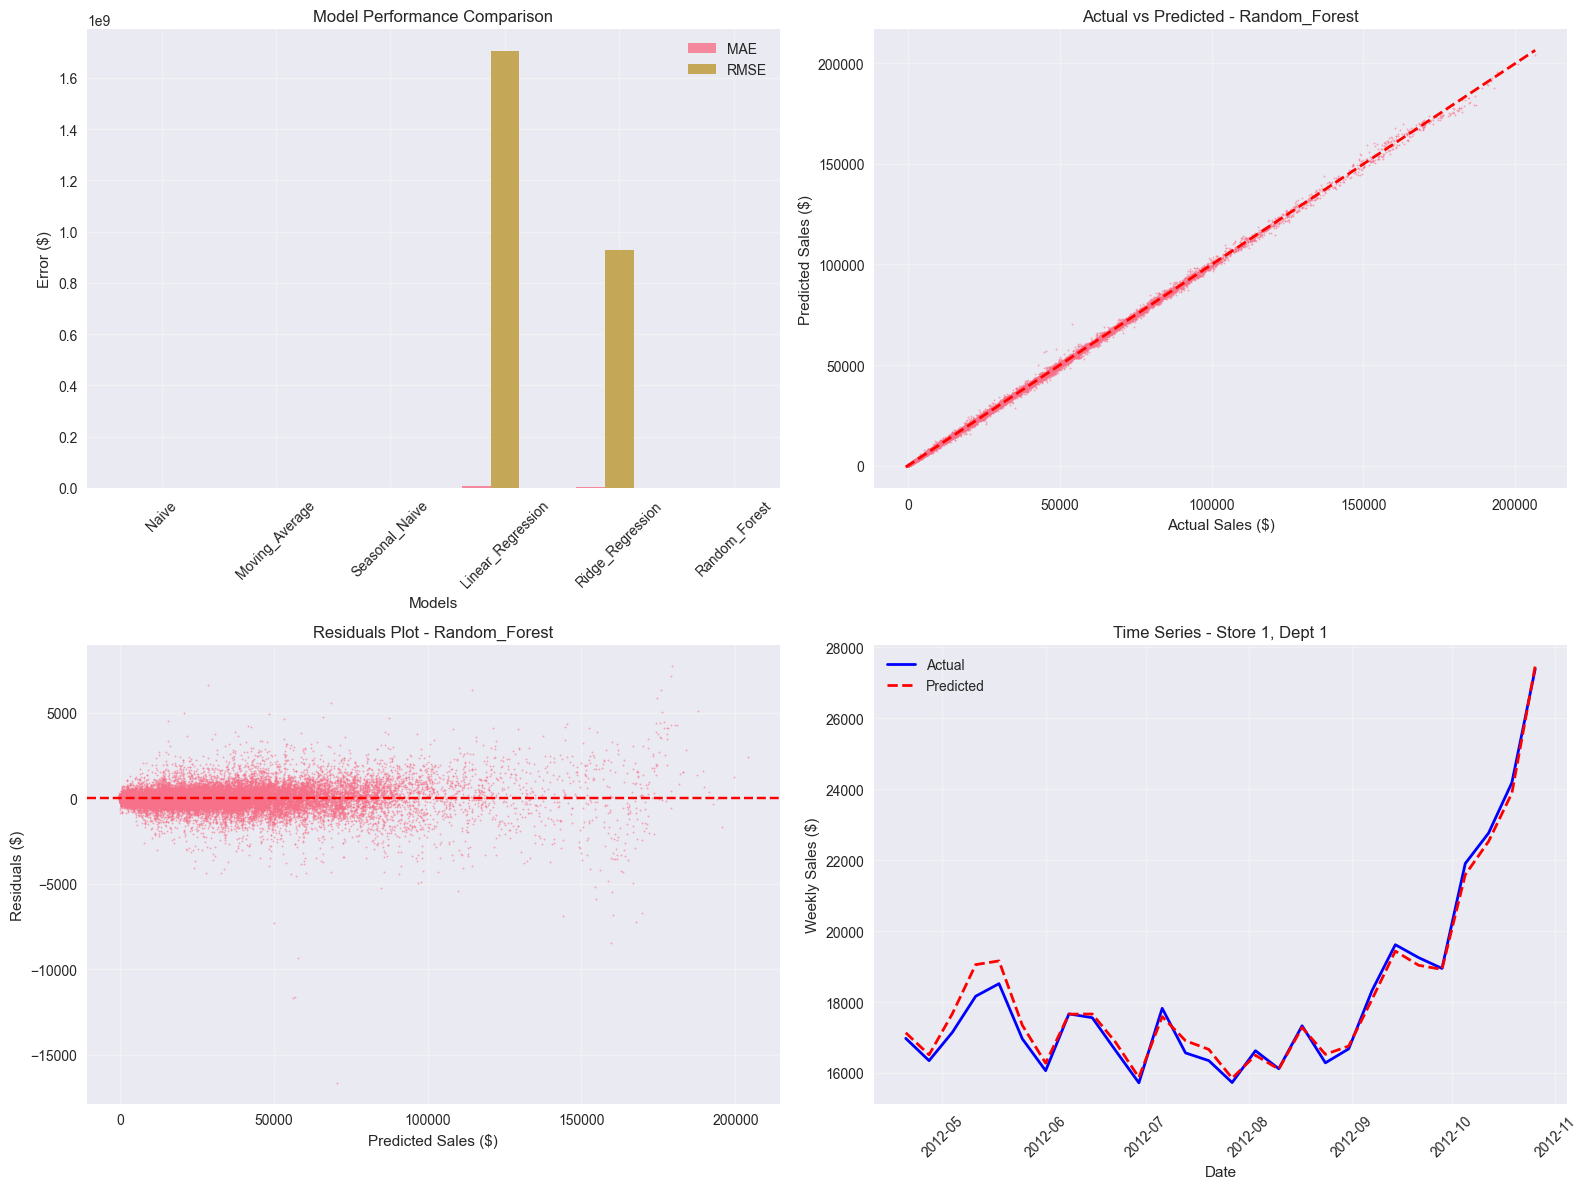

In [14]:
# Model performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model comparison bar chart
metrics_to_plot = ['MAE', 'RMSE']
if 'WMAE' in results_df.columns:
    metrics_to_plot.append('WMAE')

x_pos = np.arange(len(model_results))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    values = [model_results[model][metric] for model in model_results.keys()]
    axes[0,0].bar(x_pos + i*width, values, width, label=metric, alpha=0.8)

axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Error ($)')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(x_pos + width)
axes[0,0].set_xticklabels(model_results.keys(), rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Actual vs Predicted scatter plot (best model)
best_pred = model_predictions[best_overall]
axes[0,1].scatter(y_val, best_pred, alpha=0.5, s=1)
axes[0,1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Sales ($)')
axes[0,1].set_ylabel('Predicted Sales ($)')
axes[0,1].set_title(f'Actual vs Predicted - {best_overall}')
axes[0,1].grid(True, alpha=0.3)

# 3. Residuals plot
residuals = y_val - best_pred
axes[1,0].scatter(best_pred, residuals, alpha=0.5, s=1)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Sales ($)')
axes[1,0].set_ylabel('Residuals ($)')
axes[1,0].set_title(f'Residuals Plot - {best_overall}')
axes[1,0].grid(True, alpha=0.3)

# 4. Time series plot (sample of predictions)
# Show predictions for a sample store-department
sample_store = df['Store'].iloc[0]
sample_dept = df['Dept'].iloc[0]
sample_mask = (df['Store'] == sample_store) & (df['Dept'] == sample_dept) & val_mask

if sample_mask.sum() > 0:
    sample_dates = dates[sample_mask]
    sample_actual = target[sample_mask]
    sample_pred_indices = np.where(val_mask)[0]
    sample_indices = np.where(sample_mask)[0]
    
    # Find corresponding predictions
    pred_indices = [np.where(sample_pred_indices == idx)[0][0] for idx in sample_indices if idx in sample_pred_indices]
    
    if len(pred_indices) > 0:
        sample_pred = best_pred[pred_indices]
        
        axes[1,1].plot(sample_dates, sample_actual, 'b-', label='Actual', linewidth=2)
        axes[1,1].plot(sample_dates, sample_pred, 'r--', label='Predicted', linewidth=2)
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Weekly Sales ($)')
        axes[1,1].set_title(f'Time Series - Store {sample_store}, Dept {sample_dept}')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Results Export and Summary

In [15]:
# Save baseline model results
print("Saving baseline model results...")

# Ensure results directory exists
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)

# Save results DataFrame
results_path = '../results/reports/baseline_model_results.csv'
results_df.to_csv(results_path)
print(f"Results saved to: {results_path}")

# Save best model
if best_overall == 'Random_Forest':
    best_model_path = '../results/models/best_baseline_model.pkl'
    with open(best_model_path, 'wb') as f:
        pickle.dump(rf_model, f)
    print(f"Best model saved to: {best_model_path}")

# Save feature importance
if 'Random_Forest' in model_results:
    importance_path = '../results/reports/feature_importance_baseline.csv'
    feature_importance.to_csv(importance_path, index=False)
    print(f"Feature importance saved to: {importance_path}")

# Create comprehensive summary report
summary_report = {
    'experiment_date': datetime.now().isoformat(),
    'dataset_info': {
        'total_records': len(df),
        'train_records': len(X_train),
        'validation_records': len(X_val),
        'features_used': len(numeric_features),
        'date_range': [str(dates.min()), str(dates.max())],
        'validation_split_date': str(split_date)
    },
    'model_results': model_results,
    'best_model': best_overall,
    'key_insights': [
        f"Best performing model: {best_overall}",
        f"Validation period: {dates_val.min()} to {dates_val.max()}",
        f"Number of features used: {len(numeric_features)}",
        "Time-aware validation used to prevent data leakage"
    ]
}

summary_path = '../results/reports/baseline_models_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)
print(f"Summary report saved to: {summary_path}")

Saving baseline model results...
Results saved to: ../results/reports/baseline_model_results.csv
Best model saved to: ../results/models/best_baseline_model.pkl
Feature importance saved to: ../results/reports/feature_importance_baseline.csv
Summary report saved to: ../results/reports/baseline_models_summary.json


In [16]:
# Final summary
print("\n" + "="*80)
print("BASELINE MODELS EVALUATION COMPLETE")
print("="*80)

print(f"\n📊 Models Evaluated: {len(model_results)}")
for model_name in model_results.keys():
    print(f"   • {model_name}")

print(f"\n🎯 Performance Summary:")
print(f"   • Best Model: {best_overall}")
if 'WMAE' in results_df.columns:
    best_wmae = results_df.loc[best_overall, 'WMAE']
    print(f"   • Best WMAE: ${best_wmae:,.2f}")
best_mae = results_df.loc[best_overall, 'MAE']
best_rmse = results_df.loc[best_overall, 'RMSE']
print(f"   • Best MAE: ${best_mae:,.2f}")
print(f"   • Best RMSE: ${best_rmse:,.2f}")

print(f"\n📁 Outputs Saved:")
print(f"   • Model results: {results_path}")
print(f"   • Summary report: {summary_path}")
if 'Random_Forest' in model_results:
    print(f"   • Feature importance: {importance_path}")
    print(f"   • Best model: {best_model_path}")

print(f"\n🚀 Next Steps:")
print(f"   • Implement advanced models (XGBoost, LightGBM)")
print(f"   • Hyperparameter optimization")
print(f"   • Time series specific models (Prophet, SARIMA)")
print(f"   • Model ensembling")
print(f"   • Cross-validation with multiple folds")

print("\n" + "="*80)
print(f"Baseline models provide a solid foundation for comparison!")
print(f"Current best baseline: {best_overall}")
print("="*80)


BASELINE MODELS EVALUATION COMPLETE

📊 Models Evaluated: 6
   • Naive
   • Moving_Average
   • Seasonal_Naive
   • Linear_Regression
   • Ridge_Regression
   • Random_Forest

🎯 Performance Summary:
   • Best Model: Random_Forest
   • Best MAE: $210.95
   • Best RMSE: $431.16

📁 Outputs Saved:
   • Model results: ../results/reports/baseline_model_results.csv
   • Summary report: ../results/reports/baseline_models_summary.json
   • Feature importance: ../results/reports/feature_importance_baseline.csv
   • Best model: ../results/models/best_baseline_model.pkl

🚀 Next Steps:
   • Implement advanced models (XGBoost, LightGBM)
   • Hyperparameter optimization
   • Time series specific models (Prophet, SARIMA)
   • Model ensembling
   • Cross-validation with multiple folds

Baseline models provide a solid foundation for comparison!
Current best baseline: Random_Forest
